# Customer Segmentation using KMeans and RFM 


#### R -> Recency ( How much recently customer visited) 
#### F -> Frequency (How much frequently customer buys)
#### M -> Monetary value (How much customer spends during each shopping)

#### We will make 3 cluster on above factors. 

#### HIGH : Highest RFM Value (Best group for company)
#### MEDIUM : Medium  RFM Value
#### LOW : Least RFM Value ( group going to churn out)


In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

In [2]:
# loading dataset using pandas read method
td = pd.read_csv('Online Retail.csv', encoding = 'unicode_escape')

In [3]:
td.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [4]:
td.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

### There are 8 columns in this dataset. 
1. InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts letter with 'c', it indicates a cancellation.

2. StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.

3. Description: Product (item) name. Nominal.

4. Quantity: The quantities of each product (item) per transaction. Numeric.

5. InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.

6. UnitPrice: Unit price. Numeric, Product price per unit in sterling.

7. CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.

8. Country: Country name. Nominal, the name of the country where each customer resides. 

In [5]:
td.shape # printing shape of dataset

(541909, 8)

In [6]:
print(((td.Country.values == 'United Kingdom'). sum() / 541909) * 100)

91.43195628786383


In [7]:
td.Country.value_counts(ascending = False)
# from this we can see that majority of the customers are from United Kingdom and we can drop all we will perofrm filetring on 
# country and only keep records where country is UK
# print(((td.Country.values == 'United Kingdom'). sum() / 541909) * 100) <-- it prints % of customers from United Kingdom

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [8]:
td = td.query('Country == "United Kingdom"').reset_index(drop = True)

In [9]:
td.Country.unique()

array(['United Kingdom'], dtype=object)

In [10]:
# check for null values in dataset
td.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133600
Country             0
dtype: int64

In [11]:
td.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495478 entries, 0 to 495477
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    495478 non-null  object 
 1   StockCode    495478 non-null  object 
 2   Description  494024 non-null  object 
 3   Quantity     495478 non-null  int64  
 4   InvoiceDate  495478 non-null  object 
 5   UnitPrice    495478 non-null  float64
 6   CustomerID   361878 non-null  float64
 7   Country      495478 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 30.2+ MB


In [12]:
# Since Description is a object datatype so we can use fillna method and fill with empty string
td.Description.fillna(" ")

# Also we ca't use mean or median method on Customer id as each person have its own unique Customer id so we will use
# the notnull function
td = td[pd.notnull(td.CustomerID)]

In [13]:
td.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


### As we can see from above diagram the Quantity and Unit price have minimum value of Negative which is not possibel so we will update them and make their minimum as 0. also we will see their distribution and try to analyse whether they needs some Feature Scaling or not.

In [14]:
# assiging minimum value as 0 in Quantity and Unitprice

td.Quantity = td.Quantity.apply(lambda x : 0 if x < 0 else x) # using lambda function 

td['UnitPrice'][td['UnitPrice'] < 0] = 0 # without using lambda funciotn

In [15]:
# In RFM we need time to calculate Recency so we will convert the string date field to datetime.
td.InvoiceDate = pd.to_datetime(td.InvoiceDate)

In [16]:
# now we will make another column AMOUNT which will store Spending of each Customer and we will sue the formula 
# As Amount = Quantity * Unit Price 

td['Amount'] = td['Quantity'] * td['UnitPrice']

In [17]:
# after date preprocessing we will print our head of dataset
td.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-01-12 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-01-12 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-01-12 08:26:00,3.39,17850.0,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-01-12 08:26:00,7.65,17850.0,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-01-12 08:26:00,4.25,17850.0,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,2010-01-12 08:28:00,1.85,17850.0,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-01-12 08:28:00,1.85,17850.0,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-01-12 08:34:00,1.69,13047.0,United Kingdom,54.08


In [18]:
# prints shape of dataset after data preprocessing
td.shape

(361878, 9)

In [19]:
td.InvoiceDate.max()

Timestamp('2011-12-10 17:19:00')

## RFM MODELING 

In [20]:
'''
Recency is calulated as diffrence between Recent date and Last Invoice date (last purchase) 
Frequency is calculated as Unique values of Invoice Number (Bills)
Monetary value is calucated from Amount spent by customer
'''
import datetime as dt # for calculating recency 

c_date = dt.datetime(2011, 12, 11) # as maximum date in dataset is 10/12/2011 so we will set our current date as 11/12/2011

# Now we will create RFM modeling score for each customer

rfm_data = td.groupby('CustomerID').agg({
                        'InvoiceDate' : lambda x : (c_date - x.max()).days, 
                        'InvoiceNo' : lambda x : x.count(), 
                        'Amount' : lambda x : sum(x) })

# Now we will rename columns name to Recency, Frequency and Monetory
rfm_data.rename(columns = {
                        'InvoiceDate' : 'Recency', 
                        'InvoiceNo' : 'Frequency', 
                        'Amount' : 'Monetary' }, inplace = True)

# Now we will use resetindex to make sure that indexes are continuos.
rfm_data.reset_index(inplace = True)

In [21]:
rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,2,77183.60
1,12747.0,23,103,4196.01
2,12748.0,5,4642,33719.73
3,12749.0,23,231,4090.88
4,12820.0,45,59,942.34


In [22]:
rfm_data.describe()

,CustomerID,Recency,Frequency,Monetary
count,3950.000000,3950.000000,3950.000000,3950.000000
mean,15562.029367,101.417975,91.614684,1850.225710
std,1576.848325,114.009397,220.557389,7456.097867
min,12346.000000,0.000000,1.000000,0.000000
25%,14208.250000,20.000000,17.000000,293.025000
50%,15571.500000,58.000000,41.000000,641.980000
75%,16913.750000,153.000000,101.000000,1566.127500
max,18287.000000,697.000000,7983.000000,259657.300000


## DATA VISUALIZATION

<AxesSubplot:xlabel='Recency', ylabel='Density'>

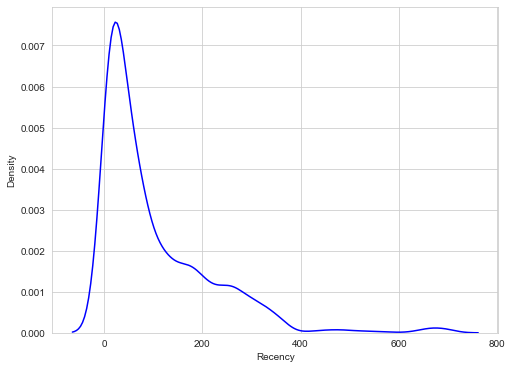

In [23]:
# now we will see distribution of RFM dataset

sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Recency 
sns.distplot(rfm_data.Recency, hist = False, color = 'b')

# After plotting graph we infer that Recency is right skewed in rfm_dataset we will perform a necceasry transformation
# to normalize it. 

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

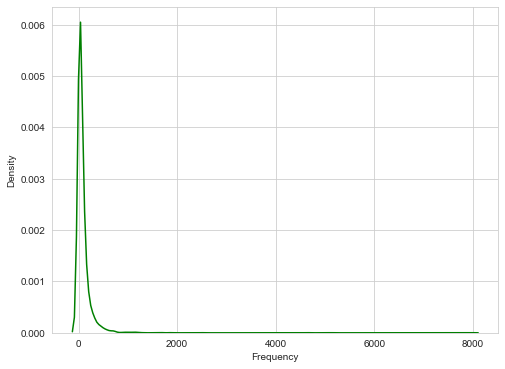

In [24]:
sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Frequency 
sns.distplot(rfm_data.Frequency, hist = False, color = 'g')

# after ploting graph we infer that majority of frequnecy value has spike at mean so
# will check in decribe to see if any changes are requiered or not

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

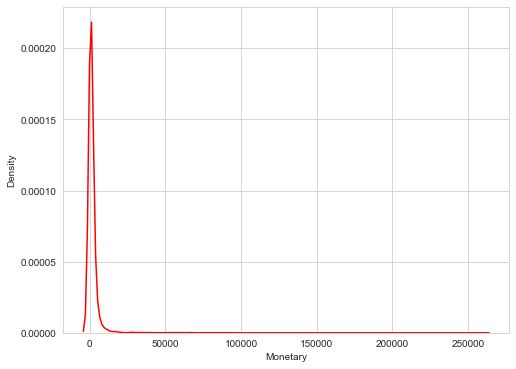

In [25]:
sns.set_style('whitegrid')
plt.figure(figsize = (8, 6))

# plotting only Monetory

sns.distplot(rfm_data.Monetary, hist = False, color = 'r')

# After ploting we infer that its greaph is same as that of the Frquency and majority of its data is present near mean

In [26]:
# Now we will divide customers into 4 segments on basis of their rfm_score for which we will create quantiles

quantiles = rfm_data.quantile(q = [0.25, 0.5, 0.75 ]) #using quantile function to get value of quantiles
quantiles = quantiles.to_dict() # coverting into dictionary for easier mapping 
quantiles

{'CustomerID': {0.25: 14208.25, 0.5: 15571.5, 0.75: 16913.75},
 'Recency': {0.25: 20.0, 0.5: 58.0, 0.75: 153.0},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 101.0},
 'Monetary': {0.25: 293.025, 0.5: 641.98, 0.75: 1566.1275000000003}}

In [27]:
# Now we will assign  R and FM score to each category and customers
def R_score(val, param):
    if val <= quantiles[param][0.25]:   return 1
    elif val <= quantiles[param][0.50]: return 2
    elif val <= quantiles[param][0.75]: return 3
    else: return 4

def FM_score(val, param):
    if val <= quantiles[param][0.25]:   return 4
    elif val <= quantiles[param][0.50]: return 3
    elif val <= quantiles[param][0.75]: return 2
    else: return 1

# here we have used same ranking method for Frequency and Monetary because higher their value higher they are loyal to company
# while in case of RECENCY lower the value of recency higher they are loyal to company.  

#in short the lowest recency, highest frequency and monetary amounts are our best customers.

In [28]:
rfm_data['R'] = rfm_data['Recency'].apply(lambda x : R_score(x, 'Recency')) # giving R score 
rfm_data['F'] = rfm_data['Frequency'].apply(lambda x : FM_score(x, 'Frequency')) # giving F score
rfm_data['M'] = rfm_data['Monetary'].apply(lambda x : FM_score(x, 'Monetary')) # giving M score

In [29]:
rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,12346.0,326,2,77183.60,4,4,1
1,12747.0,23,103,4196.01,2,1,1
2,12748.0,5,4642,33719.73,1,1,1
3,12749.0,23,231,4090.88,2,1,1
4,12820.0,45,59,942.34,2,2,2
5,12821.0,96,6,92.72,3,4,4
6,12822.0,71,47,948.88,3,2,2
7,12823.0,75,5,1759.50,3,4,1
8,12824.0,30,25,397.12,2,3,3
9,12826.0,60,94,1474.72,3,2,2


In [30]:
# Now we will add 2 another columns for rfm_data which incude rfm_score and rfm_group which will further  show that to whcih
# group it will belong. 

rfm_data['Group'] = rfm_data.R.map(str) + rfm_data.F.map(str) + rfm_data.M.map(str) 

# here we will make a new column of score which will store the score of group by adding RFM scores
rfm_data['Score'] = rfm_data[['R', 'F', 'M']].sum(axis = 1)

rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score
0,12346.0,326,2,77183.60,4,4,1,441,9
1,12747.0,23,103,4196.01,2,1,1,211,4
2,12748.0,5,4642,33719.73,1,1,1,111,3
3,12749.0,23,231,4090.88,2,1,1,211,4
4,12820.0,45,59,942.34,2,2,2,222,6
5,12821.0,96,6,92.72,3,4,4,344,11
6,12822.0,71,47,948.88,3,2,2,322,7
7,12823.0,75,5,1759.50,3,4,1,341,8
8,12824.0,30,25,397.12,2,3,3,233,8
9,12826.0,60,94,1474.72,3,2,2,322,7


In [31]:
# Now we will assign the groups to the custoemers on basis of their RFM Score which we calcluated earlier 
# in our case we will make 4 groups i.e Platinum, gold, silver and Bronze which are Membership level to the company

Membership = ['Platinum', 'Gold', 'Silver', 'Bronze']  # assigning membership level for customers

Score_cuts = pd.qcut(rfm_data.Score, q = 4, labels = Membership) # get the score using pandas.qcut method

rfm_data['Membership'] = Score_cuts.values # assign the score cuts values to new column Membership

rfm_data.head(10) # pritns the head of dataset

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership
0,12346.0,326,2,77183.60,4,4,1,441,9,Silver
1,12747.0,23,103,4196.01,2,1,1,211,4,Platinum
2,12748.0,5,4642,33719.73,1,1,1,111,3,Platinum
3,12749.0,23,231,4090.88,2,1,1,211,4,Platinum
4,12820.0,45,59,942.34,2,2,2,222,6,Gold
5,12821.0,96,6,92.72,3,4,4,344,11,Bronze
6,12822.0,71,47,948.88,3,2,2,322,7,Gold
7,12823.0,75,5,1759.50,3,4,1,341,8,Gold
8,12824.0,30,25,397.12,2,3,3,233,8,Gold
9,12826.0,60,94,1474.72,3,2,2,322,7,Gold


## DATA SCALING

In [32]:
rfm_data.head(10)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership
0,12346.0,326,2,77183.60,4,4,1,441,9,Silver
1,12747.0,23,103,4196.01,2,1,1,211,4,Platinum
2,12748.0,5,4642,33719.73,1,1,1,111,3,Platinum
3,12749.0,23,231,4090.88,2,1,1,211,4,Platinum
4,12820.0,45,59,942.34,2,2,2,222,6,Gold
5,12821.0,96,6,92.72,3,4,4,344,11,Bronze
6,12822.0,71,47,948.88,3,2,2,322,7,Gold
7,12823.0,75,5,1759.50,3,4,1,341,8,Gold
8,12824.0,30,25,397.12,2,3,3,233,8,Gold
9,12826.0,60,94,1474.72,3,2,2,322,7,Gold


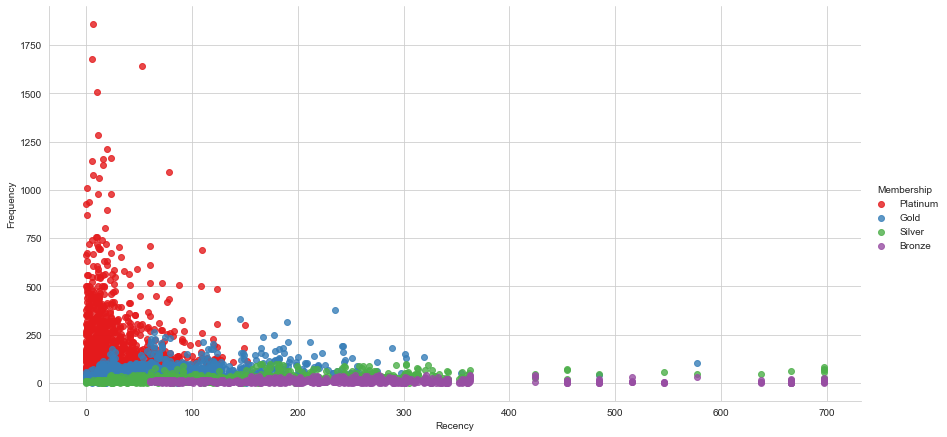

In [33]:
dist = rfm_data[rfm_data.Frequency < 2000 ] # as most of the frequency value is less than 2000 

sns.lmplot(x = 'Recency', y = 'Frequency', hue = 'Membership', data = dist, palette = 'Set1', fit_reg = False, height = 6, aspect = 2) 

In [34]:
# now we will perform feature scaling on the datset, from the distribution plot which we plotted earlier we saw that our
# data is  right skewed and we need to perform suitable normalization technique to scale our data accordingly
# so we will use LOG TRANSFORM to scale our data. 

import math

# because log(0) in nan so we will hande it explicitly
# training dataset which only contain 3 features of RFM for finding optimal value of K in Kmeans
X_train = rfm_data.iloc[:, [1, 2, 3]]

# now we will apply changes to the X_training dataset instead of the original RFM dataset
X_train.Recency = rfm_data.Recency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3)) 
X_train.Frequency = rfm_data.Frequency.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))
X_train.Monetary = rfm_data.Monetary.apply(lambda x : 0 if x == 0 else round(math.log(x), 3))

<AxesSubplot:xlabel='Recency', ylabel='Density'>

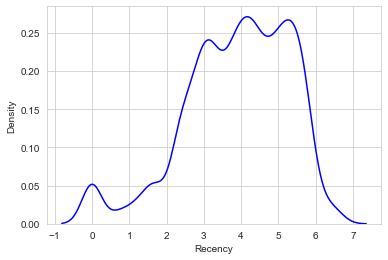

In [35]:
sns.distplot(X_train['Recency'], hist = False, color = 'b')

<AxesSubplot:xlabel='Frequency', ylabel='Density'>

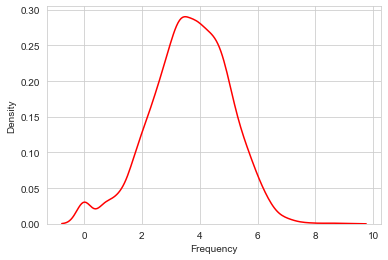

In [36]:
sns.distplot(X_train['Frequency'], hist = False, color = 'r')

<AxesSubplot:xlabel='Monetary', ylabel='Density'>

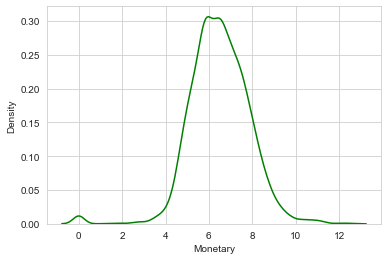

In [37]:
sns.distplot(X_train['Monetary'], hist = False, color = 'g')

In [38]:
# we will apply standard scaler to bring the dimension of X_train in same range
from sklearn.preprocessing import StandardScaler as scaler

sc = scaler() # create instance of Standardscaler

Scaled_Data = sc.fit_transform(X_train) # applying transformation to X_train

Scaled_Data = pd.DataFrame(Scaled_Data, index = rfm_data.index, columns = X_train.columns) # changing into dataframe again

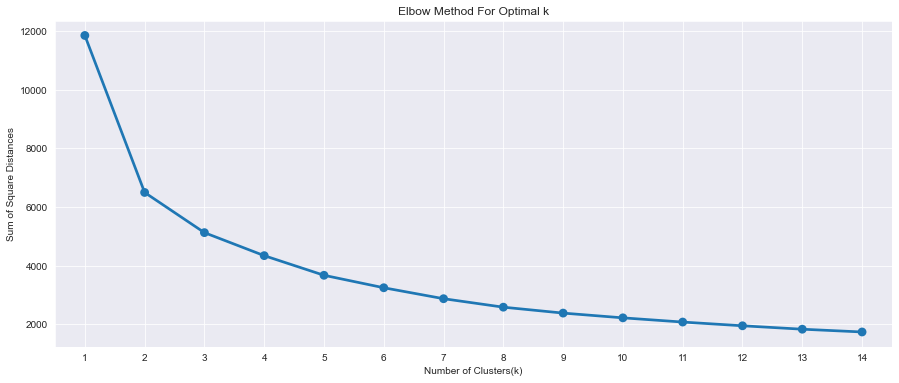

In [39]:
# Now we will find the optimal value of k in Kmeans clustering using elbow method

from sklearn.cluster import KMeans

square_dist = [] # for storing square_distance after using Kmeans model
itr = [] # for storing iteration count 

for i in range(1, 15) : 
    model = KMeans(n_clusters = i, max_iter = 1000)
    model.fit(Scaled_Data)
    square_dist.append(model.inertia_)
    itr.append(i)

# now we will plot the graphical representaion of square distance and iterations
sns.set_style('darkgrid')
plt.figure(figsize = (15, 6))
sns.pointplot(itr, square_dist, col = 'b')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.grid(True)
plt.show()

# After plotting we infer that there is sharp decrease / elbow formed when n_clusters are = 3 so we will
# create our final model using number of clusters equals to 3

In [40]:
# Now we will build the model using K Means clustering. 
model = KMeans(n_clusters = 3, max_iter = 1000) # explicitly passing number of iterations

# fitting scaled dataset into our Kmeans Model
model.fit(Scaled_Data)

# adding cluster variable to the RFM dataset to check membership level of customer. 
rfm_data['Cluster'] = model.labels_ # labels_ returns the cluster of each datapoint (similar to y_pred).

rfm_data.head(5)

,CustomerID,Recency,Frequency,Monetary,R,F,M,Group,Score,Membership,Cluster
0,12346.0,326,2,77183.60,4,4,1,441,9,Silver,1
1,12747.0,23,103,4196.01,2,1,1,211,4,Platinum,0
2,12748.0,5,4642,33719.73,1,1,1,111,3,Platinum,0
3,12749.0,23,231,4090.88,2,1,1,211,4,Platinum,0
4,12820.0,45,59,942.34,2,2,2,222,6,Gold,1


In [41]:
# Now we will plot the ouput clusters values with corresponding RFM values
# We will assign the colour RED -> platinum class cluster(0), BLUE -> gold and silver cluster(1) , GREEN -> Bronze cluster(2)

rfm_data['Colour'] = rfm_data['Cluster'].apply(lambda x : 'Red' if x == 0 else ('Green' if x == 2 else 'Blue'))

<AxesSubplot:xlabel='Recency', ylabel='Frequency'>

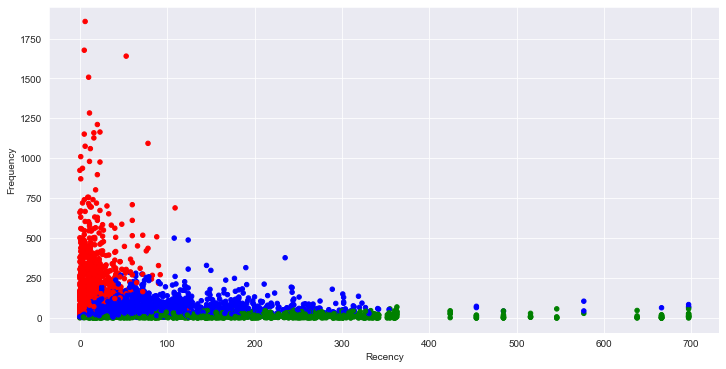

In [42]:
# Now we will plot the colour value against RFM values which tells us about the cluster in which customer belongs to

dist = rfm_data[rfm_data.Frequency < 2000 ] # as most of the frequency value is less than 2000 

dist.plot(x = 'Recency', y = 'Frequency', kind = 'scatter', c = dist['Colour'], figsize = (12, 6))